In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
     

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/plants/plant-seedlings-classification-.zip","r") as zip_ref:
    zip_ref.extractall("/content/plants/")

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from os.path import join, isdir
from os import listdir, makedirs, getcwd, remove
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import numpy as np
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models
import random
from collections import deque

use_cuda = torch.cuda.is_available()
use_cuda

True

In [ ]:
manualSeed = 999
def fixSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
fixSeed(manualSeed)

In [ ]:
import os

def find_classes(fullDir):
    classes = [d for d in os.listdir(fullDir) if os.path.isdir(os.path.join(fullDir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    num_to_class = dict(zip(range(len(classes)), classes))
    
    train = []
    for index, label in enumerate(classes):
      path = fullDir + label + '/'
      for file in listdir(path):
        train.append(['{}/{}'.format(label, file), label, index])
    
    df = pd.DataFrame(train, columns=['file', 'category', 'category_id', ])
    
    return classes, class_to_idx, num_to_class, df

In [ ]:
classes, class_to_idx, num_to_class, df = find_classes("/content/plants/train/")

In [ ]:
X, y = df.drop('category_id', axis=1), df['category_id']

print(f'X shape: {X.shape}, y shape: {y.shape}')
X.head()

X shape: (4750, 2), y shape: (4750,)


,file,category
0,Black-grass/c9f6ffa0c.png,Black-grass
1,Black-grass/37d85d833.png,Black-grass
2,Black-grass/470608aba.png,Black-grass
3,Black-grass/fc1001932.png,Black-grass
4,Black-grass/2ed589264.png,Black-grass


In [ ]:
class SeedlingDataset(Dataset):
    def __init__(self, filenames, labels, root_dir, subset=False, transform=None):
        self.filenames = filenames
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        fullname = join(self.root_dir, self.filenames.iloc[idx])
        image = Image.open(fullname).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels.iloc[idx]

In [ ]:
X, y = df.drop(['category_id', 'category'], axis=1), df['category_id']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [ ]:
print(f'train size: {X_train.shape}, validation size: {X_val.shape}, test size: {X_test.shape}')

train size: (3040, 1), validation size: (760, 1), test size: (950, 1)


In [ ]:
def train(train_loader, model, optimizer, criterion):
    model.train()
    
    losses, accuracies = [], []
    for batch_idx, (data, target) in (enumerate(train_loader)):
        correct = 0
        
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        output = model(data) # forward
        loss = criterion(output, target)
        loss.backward()
        # Calculate Accuracy
        pred = output.data.max(1)[1] # max probability
        correct += pred.eq(target.data).cpu().sum() 
        accuracy = 100. * correct / len(data)
        optimizer.step()
        
        losses.append(loss.data.item())
        accuracies.append(accuracy)
        
    return np.mean(losses), np.mean(accuracies)


def test(test_loader, criterion, model):
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum().item()
    
    test_loss /= len(test_loader) # loss function already averages over batch size
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, accuracy

def _should_early_stop(recent_validation_losses, validation_loss, early_stopping_rounds):
    recent_validation_losses.append(validation_loss)
    if early_stopping_rounds < len(recent_validation_losses):
        recent_validation_losses.popleft()
        return all(np.diff(recent_validation_losses) > 0)
    return False
    
def run_train_process(epochs, loaders, model, optimizer, criterion, early_stopping_rounds=10):
    epoch_to_results = {}
    recent_validation_losses = deque()
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train(loaders['train'], model, optimizer, criterion)
        validation_loss, validation_accuracy = test(loaders['validation'], criterion, model)
        epoch_to_results[epoch] = {
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'validation_loss': validation_loss,
            'validation_accuracy': validation_accuracy,
        }

        # Debug
        if epoch % 5 == 0:
            print('[%s] Train Accuracy: %.5f , Validation Accuracy: %.5f' % (epoch, train_accuracy, validation_accuracy))
        
        # Early Stop
        should_early_stop = _should_early_stop(recent_validation_losses, validation_loss, early_stopping_rounds)
        if should_early_stop:
            print(f'Train epoch {epoch} EARLY STOPPING - validation loss has not improved in the last {early_stopping_rounds} rounds')
            break
    
    df_epoch_to_results = pd.DataFrame.from_dict(epoch_to_results).T
    _, test_accuracy = test(loaders['test'], criterion, model)
    
    return df_epoch_to_results, test_accuracy

# **LeNet + SGD + Transformation only**

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm, tqdm_notebook

In [ ]:
class LeNet(nn.Module):
    def __init__(self, num_classes=12, num_rgb=3):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(num_rgb, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(44944, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = out.view(out.size(0), -1)
        out = self.fc3(out)
        return out

In [ ]:
learning_rate = 1e-3
lenet = LeNet().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lenet.parameters(), lr=learning_rate, momentum=0.9)

image_size = (224, 224)
train_trans = transforms.Compose([
    transforms.Resize(size=image_size),
    transforms.ToTensor()
])
validation_trans = transforms.Compose([
    transforms.Resize(size=image_size),
    transforms.ToTensor()
])

train_set = SeedlingDataset(X_train.file, y_train, '/content/plants/train/', transform=train_trans)
valid_set = SeedlingDataset(X_val.file, y_val, '/content/plants/train/', transform=validation_trans)
test_set = SeedlingDataset(X_test.file, y_test, '/content/plants/train/', transform=validation_trans)

batch_size = 8
loaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'validation': DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'test': DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0)
}
epochs = 3

df_experiment2_result, test_accuracy_experiment2 = run_train_process(epochs, loaders, lenet, optimizer, criterion)
df_experiment2_result

  0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-21-bd074e5d3251>:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
 33%|███▎      | 1/3 [01:00<02:01, 60.60s/it]

[0] Train Accuracy: 11.74342 , Validation Accuracy: 14.73684


100%|██████████| 3/3 [02:44<00:00, 54.95s/it]


,train_loss,train_accuracy,validation_loss,validation_accuracy
0,2.445079,11.743421,2.392403,14.736842
1,2.423244,13.355263,2.405590,14.736842
2,2.420441,14.111842,2.366794,14.736842


Text(0.5, 1.0, '[Lenet + SGD + Transformation only] Test Accuracy: 12.74')

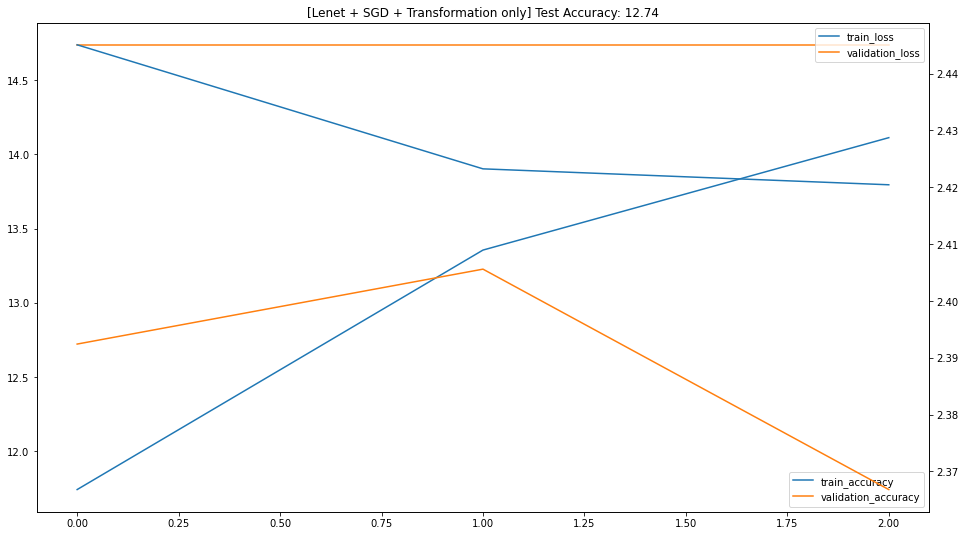

In [ ]:
ax = df_experiment2_result[['train_accuracy', 'validation_accuracy']].plot(figsize=(16,9),)
df_experiment2_result[['train_loss', 'validation_loss']].plot(ax=ax.twinx())
ax.set_title(f'[Lenet + SGD + Transformation only] Test Accuracy: {test_accuracy_experiment2:.2f}')

# **Normalizing Images and applying Computer Vision Techniques**

In [ ]:
image_size = (224, 224)
train_set = SeedlingDataset(
    X_train.file, y_train, '/content/plants/train/',
    transform=transforms.Compose([
        transforms.Resize(size=image_size),
        transforms.ToTensor()]))

means = []
means_sq = []

for img, _ in tqdm_notebook(train_set):
    means.append(np.asarray(img, dtype='float32').mean(axis=(1,2)))
    means_sq.append((np.asarray(img, dtype='float32') ** 2).mean(axis=(1,2)))

mean_img = np.mean(means, axis=0)
std_img = np.sqrt(np.mean(means_sq, axis=0) - (mean_img ** 2))

<ipython-input-18-0e1cf4118983>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img, _ in tqdm_notebook(train_set):


  0%|          | 0/3040 [00:00<?, ?it/s]

In [ ]:
mean_img, std_img

(array([0.32871813, 0.28924832, 0.20748264], dtype=float32),
 array([0.10458609, 0.110133  , 0.12714535], dtype=float32))

# **LeNet + SGD + Transform + Image Normalization**

In [ ]:
learning_rate = 1e-3
lenet = LeNet().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lenet.parameters(), lr=learning_rate, momentum=0.9)

image_size = (224, 224)
train_trans = transforms.Compose([
    transforms.Resize(size=image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean_img, std_img)
])
validation_trans = transforms.Compose([
    transforms.Resize(size=image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean_img, std_img)
])

train_set = SeedlingDataset(X_train.file, y_train, '/content/plants/train/', transform=train_trans)
valid_set = SeedlingDataset(X_val.file, y_val, '/content/plants/train/', transform=validation_trans)
test_set = SeedlingDataset(X_test.file, y_test, '/content/plants/train/', transform=validation_trans)

batch_size = 8
loaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'validation': DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'test': DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0)
}
epochs = 3

df_experiment3_part1_result, test_accuracy_experiment3_part1 = run_train_process(epochs, loaders, lenet, optimizer, criterion)
df_experiment3_part1_result

  0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-21-bd074e5d3251>:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
 33%|███▎      | 1/3 [00:54<01:49, 54.88s/it]

[0] Train Accuracy: 29.21053 , Validation Accuracy: 41.31579


100%|██████████| 3/3 [02:41<00:00, 53.72s/it]


,train_loss,train_accuracy,validation_loss,validation_accuracy
0,2.023382,29.210526,1.633957,41.315789
1,1.469203,46.611843,1.427743,50.789474
2,1.124215,59.539474,1.050534,65.789474


Text(0.5, 1.0, '[Lenet + SGD + Transform + Image Normalization] Test Accuracy: 61.68')

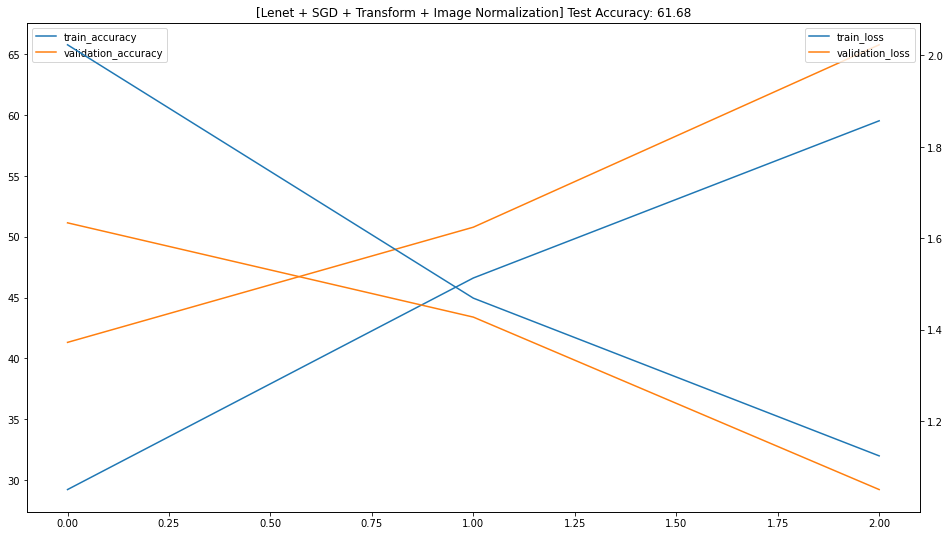

In [ ]:
ax = df_experiment3_part1_result[['train_accuracy', 'validation_accuracy']].plot(figsize=(16,9),)
df_experiment3_part1_result[['train_loss', 'validation_loss']].plot(ax=ax.twinx())
ax.set_title(f'[Lenet + SGD + Transform + Image Normalization] Test Accuracy: {test_accuracy_experiment3_part1:.2f}')

# **LeNet + SGD + Transform + Image Normalization + Data Augmentation**

# **Adding Image Data Augmentation into exisitng model**

In [ ]:
image_size = (224, 224)
batch_size = 8

train_trans = transforms.Compose([
    transforms.transforms.RandomHorizontalFlip(),
    transforms.transforms.RandomRotation(180),
    transforms.transforms.RandomVerticalFlip(),
    transforms.Resize(size=image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean_img, std_img),
])
validation_trans = transforms.Compose([
    transforms.Resize(size=image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean_img, std_img)
])

learning_rate = 1e-3
lenet = LeNet().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lenet.parameters(), lr=learning_rate, momentum=0.9)

train_set = SeedlingDataset(X_train.file, y_train, '/content/plants/train/', transform=train_trans)
valid_set = SeedlingDataset(X_val.file, y_val, '/content/plants/train/', transform=validation_trans)
test_set = SeedlingDataset(X_test.file, y_test, '/content/plants/train/', transform=validation_trans)

loaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'validation': DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'test': DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0)
}
epochs = 3

df_experiment3_part2_result, test_accuracy_experiment3_part2 = run_train_process(epochs, loaders, lenet, optimizer, criterion)
df_experiment3_part2_result

  0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-21-bd074e5d3251>:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
 33%|███▎      | 1/3 [00:57<01:55, 57.91s/it]

[0] Train Accuracy: 17.69737 , Validation Accuracy: 37.89474


100%|██████████| 3/3 [02:53<00:00, 57.93s/it]


,train_loss,train_accuracy,validation_loss,validation_accuracy
0,2.326940,17.697369,1.883401,37.894737
1,1.639163,40.888157,1.375101,50.394737
2,1.268835,54.342106,1.046573,66.710526


Text(0.5, 1.0, '[Lenet + SGD + Transform + Image Normalization + Data Augmentation] Test Accuracy: 62.32')

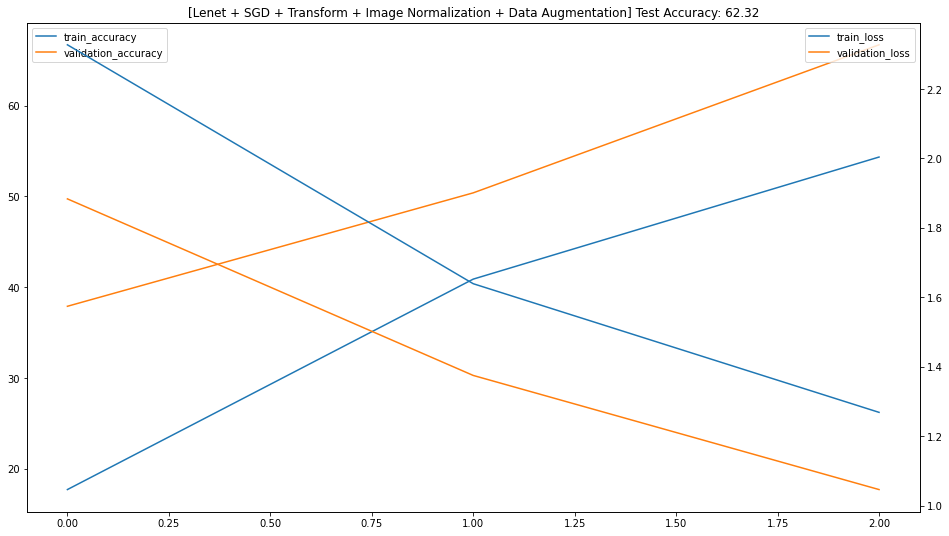

In [ ]:
ax = df_experiment3_part2_result[['train_accuracy', 'validation_accuracy']].plot(figsize=(16,9),)
df_experiment3_part2_result[['train_loss', 'validation_loss']].plot(ax=ax.twinx())
ax.set_title(f'[Lenet + SGD + Transform + Image Normalization + Data Augmentation] Test Accuracy: {test_accuracy_experiment3_part2:.2f}')

# **LeNet + SGD + Transform + Image Normalization + Data Augmentation + Kernel Size 3**

# **Changing Neural Network Architecture, Changing Kernel Size to 3**

In [ ]:
class LeNetWithKernelSize3(LeNet):
    def __init__(self, num_classes=12, num_rgb=3):
        super(LeNetWithKernelSize3, self).__init__(num_classes, num_rgb)
        self.conv1 = nn.Conv2d(num_rgb, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(46656, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

# **More Transformation and Retraining updated Network**

In [ ]:
image_size = (224, 224)
batch_size = 8

train_trans = transforms.Compose([
    transforms.transforms.RandomHorizontalFlip(),
    transforms.transforms.RandomRotation(180),
    transforms.transforms.RandomVerticalFlip(),
    transforms.Resize(size=image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean_img, std_img),
])
validation_trans = transforms.Compose([
    transforms.Resize(size=image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean_img, std_img)
])

train_set = SeedlingDataset(X_train.file, y_train, '/content/plants/train/', transform=train_trans)
valid_set = SeedlingDataset(X_val.file, y_val, '/content/plants/train/', transform=validation_trans)
test_set = SeedlingDataset(X_test.file, y_test, '/content/plants/train/', transform=validation_trans)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0)

learning_rate = 1e-3
lenet = LeNetWithKernelSize3().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lenet.parameters(), lr=learning_rate, momentum=0.9)

train_set = SeedlingDataset(X_train.file, y_train, '/content/plants/train/', transform=train_trans)
valid_set = SeedlingDataset(X_val.file, y_val, '/content/plants/train/', transform=validation_trans)
test_set = SeedlingDataset(X_test.file, y_test, '/content/plants/train/', transform=validation_trans)

batch_size = 8
loaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'validation': DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'test': DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0)
}
epochs = 3

df_experiment4_part1_result, test_accuracy_experiment4_part1 = run_train_process(epochs, loaders, lenet, optimizer, criterion)
df_experiment4_part1_result

  0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-21-bd074e5d3251>:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
 33%|███▎      | 1/3 [00:57<01:55, 57.54s/it]

[0] Train Accuracy: 15.72368 , Validation Accuracy: 24.34211


100%|██████████| 3/3 [02:50<00:00, 56.78s/it]


,train_loss,train_accuracy,validation_loss,validation_accuracy
0,2.391331,15.723684,2.291317,24.342105
1,1.972276,29.802631,1.721074,39.078947
2,1.420377,48.684212,1.169061,58.684211


Text(0.5, 1.0, '[Lenet + SGD + Transform + Image Normalization + Data Augmentation + Kernel Size 3] Test Accuracy: 56.11')

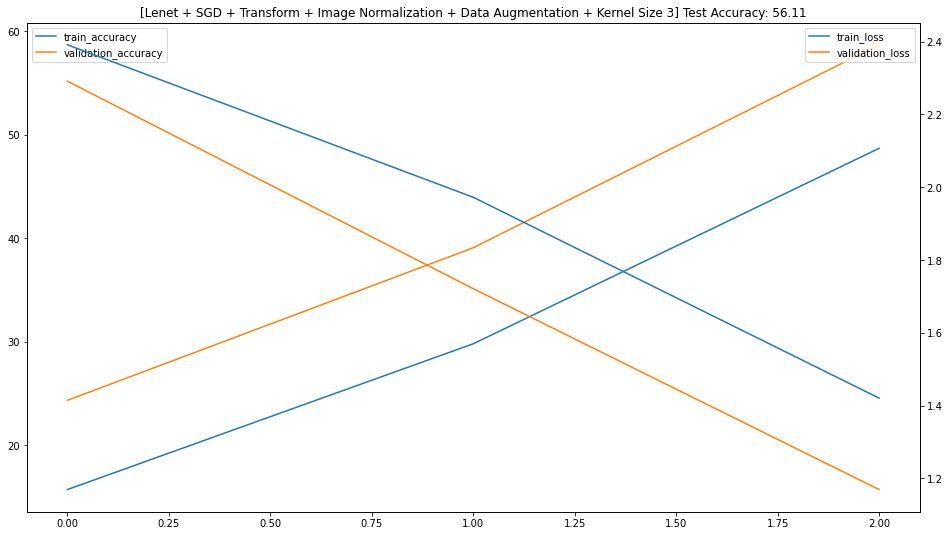

In [ ]:
ax = df_experiment4_part1_result[['train_accuracy', 'validation_accuracy']].plot(figsize=(16,9),)
df_experiment4_part1_result[['train_loss', 'validation_loss']].plot(ax=ax.twinx())
ax.set_title(f'[Lenet + SGD + Transform + Image Normalization + Data Augmentation + Kernel Size 3] Test Accuracy: {test_accuracy_experiment4_part1:.2f}')

# **LeNet + SGD + Transform + Image Normalization + Data Augmentation + Kernel Size 3 + Batch Size 32**

# **More Transformation Changing Batch size to 32**

In [ ]:
image_size = (224, 224)
batch_size = 32

train_trans = transforms.Compose([
    transforms.transforms.RandomHorizontalFlip(),
    transforms.transforms.RandomRotation(180),
    transforms.transforms.RandomVerticalFlip(),
    transforms.Resize(size=image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean_img, std_img),
])
validation_trans = transforms.Compose([
    transforms.Resize(size=image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean_img, std_img)
])

train_set = SeedlingDataset(X_train.file, y_train, '/content/plants/train/', transform=train_trans)
valid_set = SeedlingDataset(X_val.file, y_val, '/content/plants/train/', transform=validation_trans)
test_set = SeedlingDataset(X_test.file, y_test, '/content/plants/train/', transform=validation_trans)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0)

learning_rate = 1e-3
lenet = LeNetWithKernelSize3().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lenet.parameters(), lr=learning_rate, momentum=0.9)

train_set = SeedlingDataset(X_train.file, y_train, '/content/plants/train/', transform=train_trans)
valid_set = SeedlingDataset(X_val.file, y_val, '/content/plants/train/', transform=validation_trans)
test_set = SeedlingDataset(X_test.file, y_test, '/content/plants/train/', transform=validation_trans)

loaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'validation': DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'test': DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0)
}
epochs = 100

df_experiment4_part2_result, test_accuracy_experiment4_part2 = run_train_process(epochs, loaders, lenet, optimizer, criterion)
df_experiment4_part2_result

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-21-bd074e5d3251>:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
  1%|          | 1/100 [00:54<1:30:15, 54.70s/it]

[0] Train Accuracy: 12.66447 , Validation Accuracy: 14.73684


  6%|▌         | 6/100 [05:35<1:27:41, 55.98s/it]

[5] Train Accuracy: 49.86842 , Validation Accuracy: 50.92105


 11%|█         | 11/100 [10:27<1:25:56, 57.93s/it]

[10] Train Accuracy: 66.57895 , Validation Accuracy: 73.15789


 16%|█▌        | 16/100 [14:58<1:16:41, 54.78s/it]

[15] Train Accuracy: 73.48684 , Validation Accuracy: 77.10526


 21%|██        | 21/100 [19:39<1:13:23, 55.74s/it]

[20] Train Accuracy: 78.71710 , Validation Accuracy: 81.57895


 26%|██▌       | 26/100 [24:17<1:08:32, 55.57s/it]

[25] Train Accuracy: 81.48026 , Validation Accuracy: 82.36842


 31%|███       | 31/100 [28:52<1:03:28, 55.19s/it]

[30] Train Accuracy: 84.30921 , Validation Accuracy: 84.60526


 36%|███▌      | 36/100 [33:27<58:38, 54.98s/it]

[35] Train Accuracy: 87.33553 , Validation Accuracy: 87.36842


 41%|████      | 41/100 [37:59<53:28, 54.39s/it]

[40] Train Accuracy: 86.87500 , Validation Accuracy: 86.31579


 46%|████▌     | 46/100 [42:30<48:49, 54.24s/it]

[45] Train Accuracy: 88.84869 , Validation Accuracy: 87.23684


 51%|█████     | 51/100 [47:01<44:23, 54.35s/it]

[50] Train Accuracy: 90.00000 , Validation Accuracy: 86.18421


 56%|█████▌    | 56/100 [51:35<40:12, 54.84s/it]

[55] Train Accuracy: 90.49342 , Validation Accuracy: 88.55263


 61%|██████    | 61/100 [56:11<35:52, 55.18s/it]

[60] Train Accuracy: 91.67764 , Validation Accuracy: 87.23684


 66%|██████▌   | 66/100 [1:00:48<31:22, 55.35s/it]

[65] Train Accuracy: 91.97369 , Validation Accuracy: 89.34211


 71%|███████   | 71/100 [1:05:25<26:43, 55.29s/it]

[70] Train Accuracy: 92.36842 , Validation Accuracy: 88.81579


 76%|███████▌  | 76/100 [1:09:57<21:49, 54.56s/it]

[75] Train Accuracy: 93.12500 , Validation Accuracy: 88.81579


 81%|████████  | 81/100 [1:14:31<17:23, 54.92s/it]

[80] Train Accuracy: 93.25658 , Validation Accuracy: 88.81579


 86%|████████▌ | 86/100 [1:19:14<13:06, 56.18s/it]

[85] Train Accuracy: 94.04605 , Validation Accuracy: 89.60526


 91%|█████████ | 91/100 [1:23:54<08:25, 56.20s/it]

[90] Train Accuracy: 94.37500 , Validation Accuracy: 88.68421


 96%|█████████▌| 96/100 [1:28:35<03:44, 56.21s/it]

[95] Train Accuracy: 95.09869 , Validation Accuracy: 88.68421


100%|██████████| 100/100 [1:32:19<00:00, 55.39s/it]


,train_loss,train_accuracy,validation_loss,validation_accuracy
0,2.458127,12.664474,2.410838,14.736842
1,2.405358,14.769737,2.360902,14.868421
2,2.328788,20.690790,2.285184,28.289474
3,2.042746,35.230263,1.756461,44.210526
4,1.604038,43.914474,1.466283,48.684211
...,...,...,...,...
95,0.132021,95.098686,0.484379,88.684211
96,0.120497,95.230263,0.461613,90.131579
97,0.132558,94.934212,0.493507,88.421053
98,0.115449,95.328949,0.500404,89.210526


Text(0.5, 1.0, '[Lenet + SGD + Transform + Image Normalization + Data Augmentation + Kernel Size 3 + Batch Size 32] Test Accuracy: 86.95')

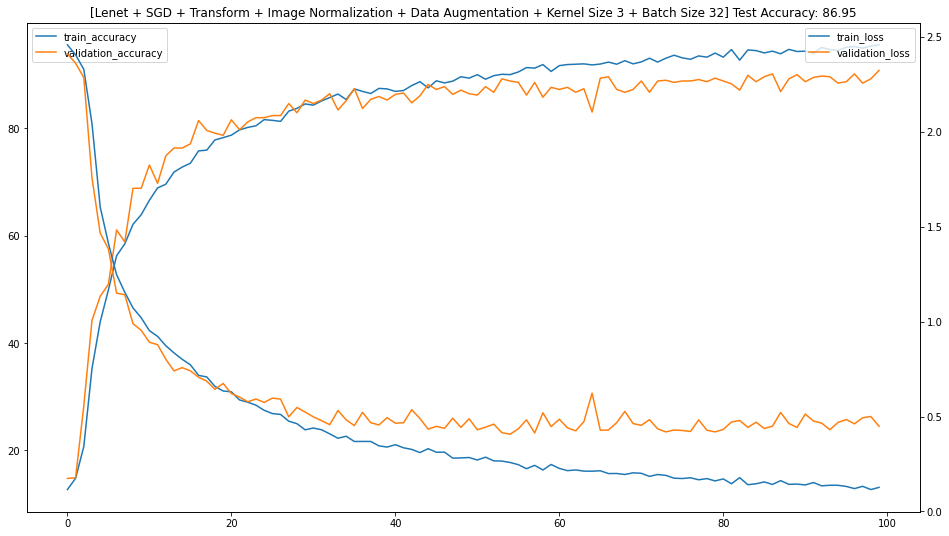

In [ ]:
ax = df_experiment4_part2_result[['train_accuracy', 'validation_accuracy']].plot(figsize=(16,9),)
df_experiment4_part2_result[['train_loss', 'validation_loss']].plot(ax=ax.twinx())
ax.set_title(f'[Lenet + SGD + Transform + Image Normalization + Data Augmentation + Kernel Size 3 + Batch Size 32] Test Accuracy: {test_accuracy_experiment4_part2:.2f}')

# **LeNet + Adam Optimizer + Transform + Image Normalization + Data Augmentation + Batch Size 32**

In [ ]:
image_size = (224, 224)
batch_size = 32

train_trans = transforms.Compose([
    transforms.transforms.RandomHorizontalFlip(),
    transforms.transforms.RandomRotation(180),
    transforms.transforms.RandomVerticalFlip(),
    transforms.Resize(size=image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean_img, std_img),
])
validation_trans = transforms.Compose([
    transforms.Resize(size=image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean_img, std_img)
])

train_set = SeedlingDataset(X_train.file, y_train, '/content/plants/train/', transform=train_trans)
valid_set = SeedlingDataset(X_val.file, y_val, '/content/plants/train/', transform=validation_trans)
test_set = SeedlingDataset(X_test.file, y_test, '/content/plants/train/', transform=validation_trans)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0)

learning_rate = 1e-3
lenet = LeNet().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet.parameters(), lr=learning_rate)

train_set = SeedlingDataset(X_train.file, y_train, '/content/plants/train/', transform=train_trans)
valid_set = SeedlingDataset(X_val.file, y_val, '/content/plants/train/', transform=validation_trans)
test_set = SeedlingDataset(X_test.file, y_test, '/content/plants/train/', transform=validation_trans)

loaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'validation': DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'test': DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0)
}
epochs = 100

df_experiment5_part2_result, test_accuracy_experiment5_part2 = run_train_process(epochs, loaders, lenet, optimizer, criterion)
df_experiment5_part2_result

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-21-bd074e5d3251>:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
  1%|          | 1/100 [00:58<1:35:43, 58.02s/it]

[0] Train Accuracy: 28.88158 , Validation Accuracy: 50.13158


  2%|▏         | 2/100 [02:55<2:23:25, 87.81s/it]


KeyboardInterrupt: ignored

In [ ]:
ax = df_experiment5_part2_result[['train_accuracy', 'validation_accuracy']].plot(figsize=(16,9),)
df_experiment5_part2_result[['train_loss', 'validation_loss']].plot(ax=ax.twinx())
ax.set_title(f'[Lenet + Adam Optimizer + Transform + Image Normalization + Data Augmentation + Batch Size 32] Test Accuracy: {test_accuracy_experiment5_part2:.2f}')

# **VGG16 Transfer Learning + SGD + Transform + Image Normalization + Data Augmentation + Batch Size 32**

In [ ]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16_bn(pretrained=True)
print(f'Number of output fearurs of pretrained vgg is: {vgg16.classifier[6].out_features}') # 1000

# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
print(f'Last layer of vgg16 has {num_features} input features.')
print(f'Removing layer: {list(vgg16.classifier.children())[-1]}')
classifier_layers = list(vgg16.classifier.children())[:-1] # Remove last layer
layer_to_add = nn.Linear(num_features, len(np.unique(y)))
print(f'Adding layer: {layer_to_add}')
classifier_layers.extend([layer_to_add]) # Add our layer with 4 outputs
vgg16.classifier = nn.Sequential(*classifier_layers) # Replace the model classifier

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Number of output fearurs of pretrained vgg is: 1000
Last layer of vgg16 has 4096 input features.
Removing layer: Linear(in_features=4096, out_features=1000, bias=True)
Adding layer: Linear(in_features=4096, out_features=12, bias=True)


In [ ]:
image_size = (224, 224)
batch_size = 32

train_trans = transforms.Compose([
    transforms.transforms.RandomHorizontalFlip(),
    transforms.transforms.RandomRotation(180),
    transforms.transforms.RandomVerticalFlip(),
    transforms.Resize(size=image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean_img, std_img),
])
validation_trans = transforms.Compose([
    transforms.Resize(size=image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean_img, std_img)
])

train_set = SeedlingDataset(X_train.file, y_train, '/content/plants/train/', transform=train_trans)
valid_set = SeedlingDataset(X_val.file, y_val, '/content/plants/train/', transform=validation_trans)
test_set = SeedlingDataset(X_test.file, y_test, '/content/plants/train/', transform=validation_trans)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0)

learning_rate = 1e-3
vgg = vgg16.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg.parameters(), lr=0.001, momentum=0.9)

train_set = SeedlingDataset(X_train.file, y_train, '/content/plants/train/', transform=train_trans)
valid_set = SeedlingDataset(X_val.file, y_val, '/content/plants/train/', transform=validation_trans)
test_set = SeedlingDataset(X_test.file, y_test, '/content/plants/train/', transform=validation_trans)

loaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'validation': DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'test': DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0)
}
epochs = 30

df_experiment8_result, test_accuracy_experiment8 = run_train_process(epochs, loaders, vgg, optimizer, criterion)
df_experiment8_result

  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-21-bd074e5d3251>:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
  3%|▎         | 1/30 [01:52<54:23, 112.53s/it]

[0] Train Accuracy: 52.07237 , Validation Accuracy: 81.05263


 20%|██        | 6/30 [11:11<44:41, 111.73s/it]

[5] Train Accuracy: 93.94736 , Validation Accuracy: 93.15789


 37%|███▋      | 11/30 [20:11<34:18, 108.32s/it]

[10] Train Accuracy: 97.03947 , Validation Accuracy: 95.78947


 53%|█████▎    | 16/30 [29:09<25:15, 108.27s/it]

[15] Train Accuracy: 97.26974 , Validation Accuracy: 94.86842


 70%|███████   | 21/30 [38:17<16:23, 109.29s/it]

[20] Train Accuracy: 98.51974 , Validation Accuracy: 94.73684


 87%|████████▋ | 26/30 [47:23<07:17, 109.30s/it]

[25] Train Accuracy: 99.11184 , Validation Accuracy: 95.13158


100%|██████████| 30/30 [54:40<00:00, 109.35s/it]


,train_loss,train_accuracy,validation_loss,validation_accuracy
0,1.519311,52.072369,0.633836,81.052632
1,0.437254,84.638161,0.361608,88.552632
2,0.280358,90.559212,0.284796,90.526316
3,0.215013,92.763161,0.231445,91.842105
4,0.182894,93.717102,0.200179,93.421053
5,0.178526,93.947365,0.185481,93.157895
6,0.146925,94.473686,0.173607,93.947368
7,0.143727,94.835526,0.156599,94.605263
8,0.117433,96.315788,0.170821,94.210526
9,0.112654,96.151314,0.153728,94.342105


Text(0.5, 1.0, '[Transfer Learning with VGG16 + SGD + Transform + Image Normalization + Data Augmentation + Batch Size 32] Test Accuracy: 95.26')

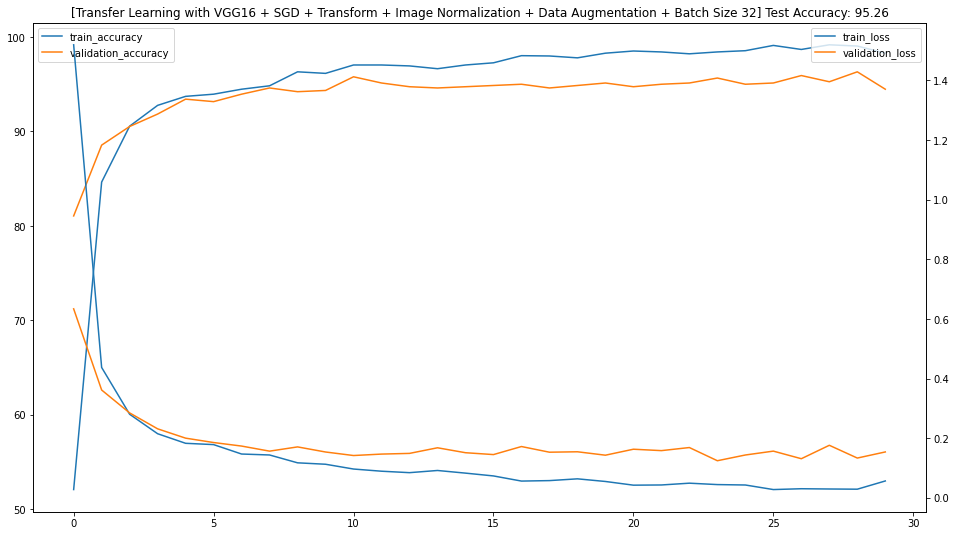

In [ ]:
ax = df_experiment8_result[['train_accuracy', 'validation_accuracy']].plot(figsize=(16,9),)
df_experiment8_result[['train_loss', 'validation_loss']].plot(ax=ax.twinx())
ax.set_title(f'[Transfer Learning with VGG16 + SGD + Transform + Image Normalization + Data Augmentation + Batch Size 32] Test Accuracy: {test_accuracy_experiment8:.2f}')

# **RESNET50 Transfer Learning + 30 Epochs + SGD + Transform + Image Normalization + Data Augmentation + Batch Size 32**

In [ ]:
# Load the pretrained model from pytorch
resnet50 = models.resnet50(pretrained=True)
print(f'Number of output fearurs of pretrained resnet50 is: {resnet50.fc.out_features}') # 1000

# Freeze training for all layers
for param in resnet50.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
fc_inputs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 12), 
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Number of output fearurs of pretrained resnet50 is: 1000


In [ ]:
image_size = (224, 224)
batch_size = 32

train_trans = transforms.Compose([
    transforms.transforms.RandomHorizontalFlip(),
    transforms.transforms.RandomRotation(180),
    transforms.transforms.RandomVerticalFlip(),
    transforms.Resize(size=image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean_img, std_img),
])
validation_trans = transforms.Compose([
    transforms.Resize(size=image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean_img, std_img)
])

train_set = SeedlingDataset(X_train.file, y_train, '/content/plants/train/', transform=train_trans)
valid_set = SeedlingDataset(X_val.file, y_val, '/content/plants/train/', transform=validation_trans)
test_set = SeedlingDataset(X_test.file, y_test, '/content/plants/train/', transform=validation_trans)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0)

learning_rate = 1e-3
resnet50 = resnet50.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)

train_set = SeedlingDataset(X_train.file, y_train, '/content/plants/train/', transform=train_trans)
valid_set = SeedlingDataset(X_val.file, y_val, '/content/plants/train/', transform=validation_trans)
test_set = SeedlingDataset(X_test.file, y_test, '/content/plants/train/', transform=validation_trans)

loaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'validation': DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'test': DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0)
}
epochs = 30

df_experiment9_result, test_accuracy_experiment9 = run_train_process(epochs, loaders, resnet50, optimizer, criterion)
df_experiment9_result

  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-15-bd074e5d3251>:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
  3%|▎         | 1/30 [01:26<41:39, 86.21s/it]

[0] Train Accuracy: 29.63816 , Validation Accuracy: 48.28947


 20%|██        | 6/30 [08:21<33:16, 83.19s/it]

[5] Train Accuracy: 91.38158 , Validation Accuracy: 90.92105


 37%|███▋      | 11/30 [15:24<26:51, 84.81s/it]

[10] Train Accuracy: 95.06579 , Validation Accuracy: 92.76316


 53%|█████▎    | 16/30 [22:26<19:40, 84.29s/it]

[15] Train Accuracy: 96.80921 , Validation Accuracy: 93.55263


 70%|███████   | 21/30 [29:26<12:36, 84.01s/it]

[20] Train Accuracy: 97.43421 , Validation Accuracy: 96.57895


 87%|████████▋ | 26/30 [36:38<05:43, 85.97s/it]

[25] Train Accuracy: 98.02631 , Validation Accuracy: 95.39474


100%|██████████| 30/30 [42:13<00:00, 84.46s/it]


,train_loss,train_accuracy,validation_loss,validation_accuracy
0,2.237494,29.638159,1.858650,48.289474
1,1.294161,62.236843,0.866077,78.815789
2,0.608943,82.368423,0.512607,84.868421
3,0.374789,89.046051,0.357446,90.131579
4,0.288922,90.723686,0.306555,89.868421
5,0.244584,91.381577,0.279740,90.921053
6,0.212909,93.651314,0.257158,92.500000
7,0.182457,93.947365,0.239589,91.447368
8,0.179184,94.078949,0.199082,94.210526
9,0.157665,95.065788,0.206357,93.552632


Text(0.5, 1.0, '[Transfer Learning with Resnet50 + 30 Epochs + SGD + Transform + Image Normalization + Data Augmentation + Batch Size 32] Test Accuracy: 93.89')

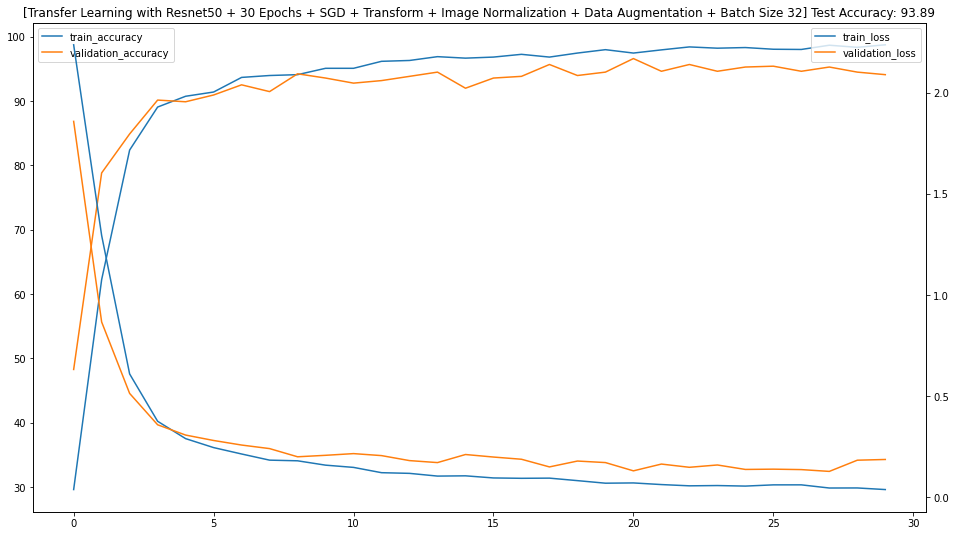

In [ ]:
ax = df_experiment9_result[['train_accuracy', 'validation_accuracy']].plot(figsize=(16,9),)
df_experiment9_result[['train_loss', 'validation_loss']].plot(ax=ax.twinx())
ax.set_title(f'[Transfer Learning with Resnet50 + 30 Epochs + SGD + Transform + Image Normalization + Data Augmentation + Batch Size 32] Test Accuracy: {test_accuracy_experiment9:.2f}')